Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.67      0.55        27
           1       0.00      0.00      0.00         2
           2       0.55      0.37      0.44        30

    accuracy                           0.49        59
   macro avg       0.34      0.34      0.33        59
weighted avg       0.49      0.49      0.47        59

Mean next-day return by predicted signal class:
predicted
0   -0.009620
2    0.048549
Name: next_return, dtype: float64


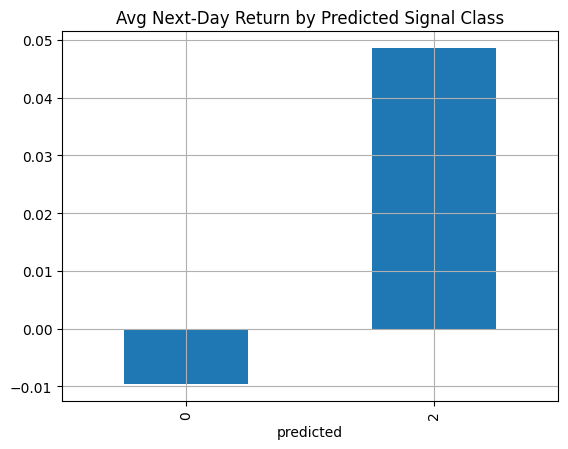

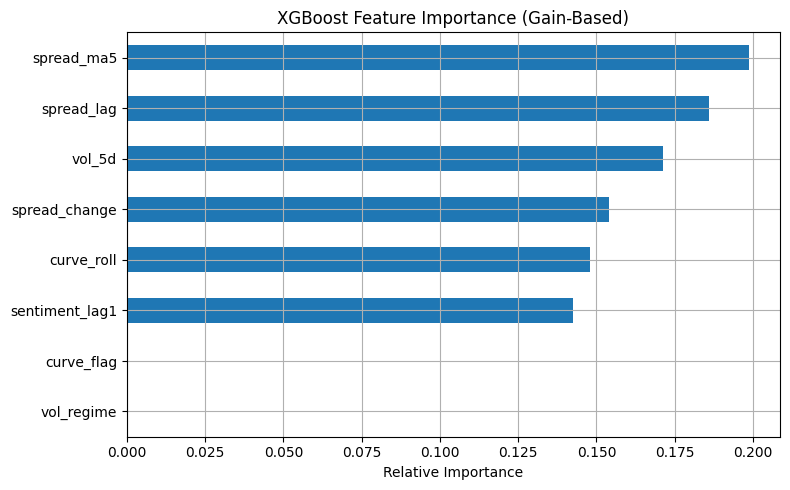

In [11]:
# Week 7 — Brent-WTI Regime-Sliced Signal with Sentiment Overlay
# Author: Blaine Hodder

# --- Config ---
USE_YFINANCE = False  # Set to True when rate-limiting ends

# --- Imports ---
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import time
import warnings
warnings.filterwarnings("ignore") # Supressing warnings like deprecation

# --- Load Data ---
if USE_YFINANCE:
    start = "2023-01-01"
    end = "2024-12-31"
    brent_df = yf.download("BZ=F", start=start, end=end)
    time.sleep(2)
    wti_df = yf.download("CL=F", start=start, end=end)
    time.sleep(2)
    wti2_df = yf.download("CL2=F", start=start, end=end)

    df = pd.DataFrame()
    df['date'] = brent_df.index

    # Start from Brent and rename
    df = brent_df[['Adj Close']].rename(columns={'Adj Close': 'brent'})

    # Join WTI and WTI2 on date index
    df = df.join(wti_df[['Adj Close']].rename(columns={'Adj Close': 'wti'}))
    df = df.join(wti2_df[['Adj Close']].rename(columns={'Adj Close': 'wti_2'}))
    df.reset_index(inplace=True)  # 'date' column instead of it staying as index


else:
    # Simulated fallback data if you get throttled from Yahoo feed
    dates = pd.date_range(start="2023-01-01", periods=300)
    np.random.seed(42)
    brent = 85 + np.cumsum(np.random.normal(0, 0.4, len(dates)))
    wti = 82 + np.cumsum(np.random.normal(0, 0.4, len(dates)))
    wti2 = wti - np.random.normal(0.2, 0.1, len(dates))

    df = pd.DataFrame({
        'date': dates,
        'brent': brent,
        'wti': wti,
        'wti_2': wti2
    })

# --- Feature Engineering ---
df['brent_wti_spread'] = df['brent'] - df['wti']
df['spread_lag'] = df['brent_wti_spread'].shift(1)
df['spread_change'] = df['brent_wti_spread'].pct_change()
df['spread_ma5'] = df['brent_wti_spread'].rolling(5).mean()
df['curve_roll'] = df['wti'] - df['wti_2']
df['curve_flag'] = np.where(df['curve_roll'] > 0, 1, 0)
df['wti_return'] = df['wti'].pct_change()
df['vol_5d'] = df['wti_return'].rolling(5).std()
vol_threshold = df['vol_5d'].median()
df['vol_regime'] = np.where(df['vol_5d'] > vol_threshold, 1, 0)
df['next_return'] = df['brent_wti_spread'].pct_change().shift(-1)
df['label'] = df['next_return'].apply(lambda x: 2 if x > 0.003 else (0 if x < -0.003 else 1)) # This is our target classification for long/short

# Simulated sentiment
df['sentiment_score'] = np.random.normal(0, 0.1, len(df))
df['sentiment_lag1'] = df['sentiment_score'].shift(1)

df = df.dropna()

# --- Modeling ---
features = ['spread_lag', 'spread_change', 'spread_ma5',
            'curve_roll', 'curve_flag', 'vol_5d', 'vol_regime', 'sentiment_lag1']

X = df[features] #Features
y = df['label'] #Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# --- Return Performance by Prediction Bucket ---
df_test = df.iloc[-len(y_test):].copy()
df_test['predicted'] = y_pred
grouped_returns = df_test.groupby('predicted')['next_return'].mean()
print("Mean next-day return by predicted signal class:")
print(grouped_returns)

grouped_returns.plot(kind='bar', title="Avg Next-Day Return by Predicted Signal Class")
plt.grid()
plt.show()

feature_importance = pd.Series(model.feature_importances_, index=features)
feature_importance = feature_importance.sort_values(ascending=True)

plt.figure(figsize=(8, 5))
feature_importance.plot(kind='barh', title="XGBoost Feature Importance (Gain-Based)")
plt.grid(True)
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()